Q1. Dataset
Use the SMS Spam Collection Dataset
(Source: UCI / Kaggle → spam.csv)
Task
Classify SMS messages as:
•	spam (1)
•	ham (0) — not spam
Data Description
Column	Meaning
label	spam / ham
text	SMS message content
There are ~5,500 messages


Part A — Data Preprocessing & Exploration
1.	Load the SMS spam dataset

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('stopwords')
nltk.download('punkt')
df = pd.read_csv('spam.csv', encoding='latin-1')
print(df.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2.	Convert label: "spam" → 1, "ham" → 0


Class Distribution:
label
0    0.865937
1    0.134063
Name: proportion, dtype: float64


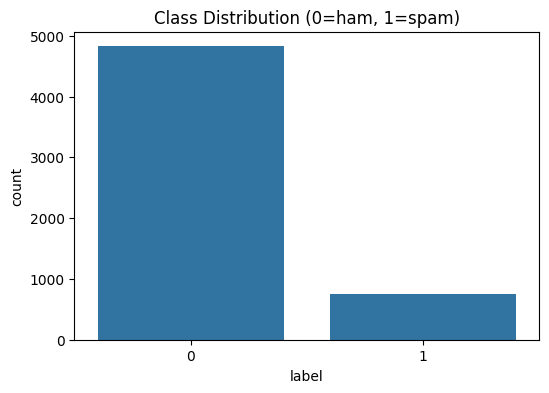

In [20]:
if not df.empty:
    df = df.iloc[:, :2]
    df.columns = ['label', 'text']

    df['label'] = df['label'].map({'ham': 0, 'spam': 1})
    print("\nClass Distribution:")
    print(df['label'].value_counts(normalize=True))

    plt.figure(figsize=(6, 4))
    sns.countplot(x='label', data=df)
    plt.title('Class Distribution (0=ham, 1=spam)')
    plt.show()

3.	Text preprocessing:
o	Lowercase
o	Remove punctuation
o	Remove stopwords
4.	Convert text to numeric feature vectors using TF-IDF vectorizer
5.	Train–test split (80/20)
6.	Show class distribution

In [21]:
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens_no_punct = [t for t in tokens if t not in string.punctuation]
    tokens_no_stop = [t for t in tokens_no_punct if t not in stop_words]
    return ' '.join(tokens_no_stop)

df['clean_text'] = df['text'].apply(preprocess_text)
print(df[['text', 'clean_text']].head())

tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

print(f"TF-IDF Training data shape: {X_train.shape}")
print(f"TF-IDF Testing data shape: {X_test.shape}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                          clean_text  
0  go jurong point crazy .. available bugis n gre...  
1                    ok lar ... joking wif u oni ...  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3        u dun say early hor ... u c already say ...  
4         nah n't think goes usf lives around though  
TF-IDF Training data shape: (4457, 3000)
TF-IDF Testing data shape: (1115, 3000)


Part B — Weak Learner Baseline
Train a Decision Stump:
DecisionTreeClassifier(max_depth=1)
Report:
•	Train accuracy
•	Test accuracy
•	Confusion matrix
•	Comment on why stump performance is weak on text data

Train Accuracy: 0.8836
Test Accuracy: 0.8951



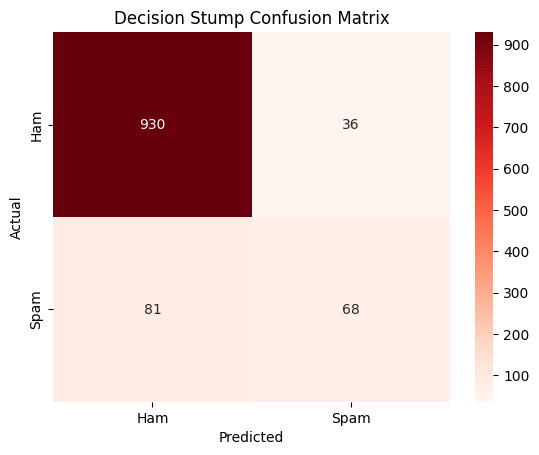

In [22]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_pred_train_stump = stump.predict(X_train)
train_acc_stump = accuracy_score(y_train, y_pred_train_stump)
print(f"Train Accuracy: {train_acc_stump:.4f}")

y_pred_test_stump = stump.predict(X_test)
test_acc_stump = accuracy_score(y_test, y_pred_test_stump)
print(f"Test Accuracy: {test_acc_stump:.4f}\n")
cm_stump = confusion_matrix(y_test, y_pred_test_stump)
sns.heatmap(cm_stump, annot=True, fmt='d', cmap='Reds',xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Stump Confusion Matrix')
plt.show()

Part C — Manual AdaBoost (T = 15 rounds)
Implement AdaBoost from scratch and after each iteration, print:
•	Iteration number
•	Misclassified sample indices
•	Weights of misclassified samples
•	Alpha value
Then update and normalize weights.
Also produce:
•	Plot: iteration vs weighted error
•	Plot: iteration vs alpha
Finally report:
•	Train accuracy
•	Test accuracy
•	Confusion matrix
•	Short interpretation of weight evolution


In [23]:
y_train_m1 = y_train.map({0: -1, 1: 1}).values

N = len(y_train)
T = 15

weights = np.full(N, 1/N)

stumps = []
alphas = []
weighted_errors = []
iteration_numbers = list(range(1, T + 1))
X_train_dense = X_train.toarray()
y_train_arr = y_train.values

for t in iteration_numbers:
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_train, y_train, sample_weight=weights)

    y_pred_stump = stump.predict(X_train)
    y_pred_stump_m1 = np.array([1 if p == 1 else -1 for p in y_pred_stump])

    misclassified_mask = (y_pred_stump != y_train_arr)
    misclassified_indices = np.where(misclassified_mask)[0]

    error = np.sum(weights[misclassified_mask])
    error = max(error, 1e-9)
    weighted_errors.append(error)

    alpha = 0.5 * np.log((1 - error) / error)
    alphas.append(alpha)
    print(f"Misclassified sample indices (first 20): {misclassified_indices[:20]}")
    print(f"Weights of misclassified (first 20): {weights[misclassified_indices[:20]]}")
    print(f"Weighted Error (Epsilon): {error:.6f}")
    print(f"Alpha: {alpha:.6f}")

    weights = weights * np.exp(-alpha * y_train_m1 * y_pred_stump_m1)
    weights = weights / np.sum(weights)
    stumps.append(stump)


Misclassified sample indices (first 20): [ 14  42  49  50  59  62  86  93  96 100 103 115 121 140 142 157 162 194
 195 196]
Weights of misclassified (first 20): [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437]
Weighted Error (Epsilon): 0.116446
Alpha: 1.013262
Misclassified sample indices (first 20): [  9  15  22  31  39  49  59  66  76  88  93 114 121 123 159 162 166 174
 194 203]
Weights of misclassified (first 20): [0.00012697 0.00012697 0.00012697 0.00012697 0.00012697 0.00096339
 0.00096339 0.00012697 0.00012697 0.00012697 0.00096339 0.00012697
 0.00096339 0.00012697 0.00012697 0.00096339 0.00012697 0.00012697
 0.00096339 0.00096339]
Weighted Error (Epsilon): 0.247721
Alpha: 0.555402
Misclassified sample indices (first 20): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16 17 18 19 20 21]
Weights of misclassifie

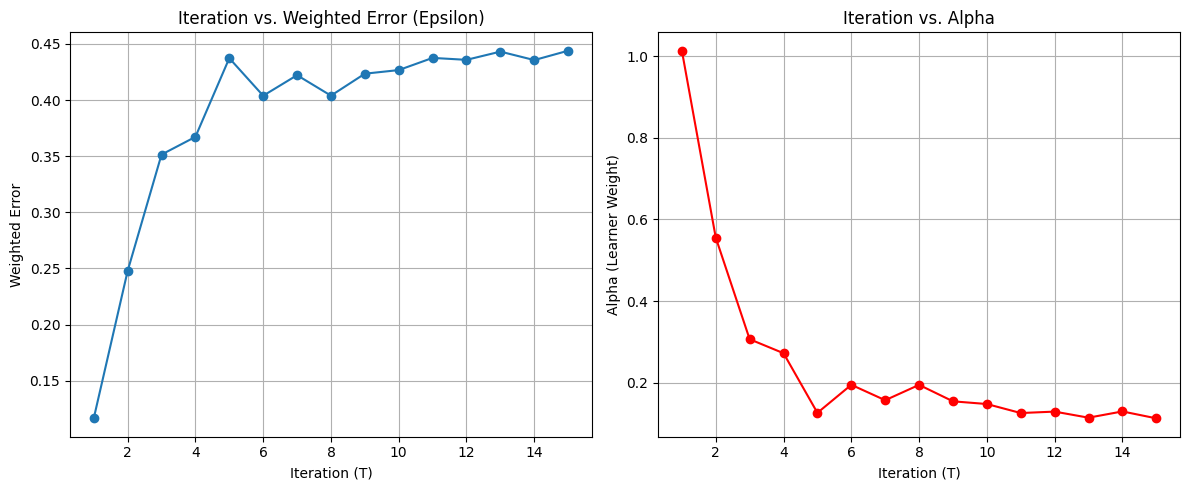

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(iteration_numbers, weighted_errors, marker='o')
plt.title('Iteration vs. Weighted Error (Epsilon)')
plt.xlabel('Iteration (T)')
plt.ylabel('Weighted Error')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(iteration_numbers, alphas, marker='o', color='r')
plt.title('Iteration vs. Alpha')
plt.xlabel('Iteration (T)')
plt.ylabel('Alpha (Learner Weight)')
plt.grid(True)

plt.tight_layout()
plt.show()

Train Accuracy: 0.9172
Test Accuracy: 0.9256



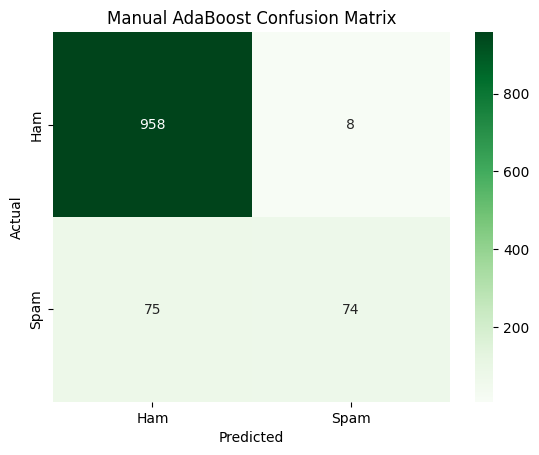

In [25]:
def manual_adaboost_predict(X):
    stump_preds = np.array([stump.predict(X) for stump in stumps])
    stump_preds_m1 = np.where(stump_preds == 1, 1, -1)

    final_scores = np.dot(alphas, stump_preds_m1)
    final_preds = np.sign(final_scores)
    return np.where(final_preds == 1, 1, 0)

y_pred_train_manual = manual_adaboost_predict(X_train)
train_acc_manual = accuracy_score(y_train, y_pred_train_manual)
print(f"Train Accuracy: {train_acc_manual:.4f}")

y_pred_test_manual = manual_adaboost_predict(X_test)
test_acc_manual = accuracy_score(y_test, y_pred_test_manual)
print(f"Test Accuracy: {test_acc_manual:.4f}\n")

cm_manual = confusion_matrix(y_test, y_pred_test_manual)
sns.heatmap(cm_manual, annot=True, fmt='d', cmap='Greens',xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Manual AdaBoost Confusion Matrix')
plt.show()

Part D — Sklearn AdaBoost
Train:
AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)
Report:
•	Train accuracy
•	Test accuracy
•	Confusion matrix
•	Compare performance with manual implementation

Train Accuracy: 0.9147
Test Accuracy: 0.9184



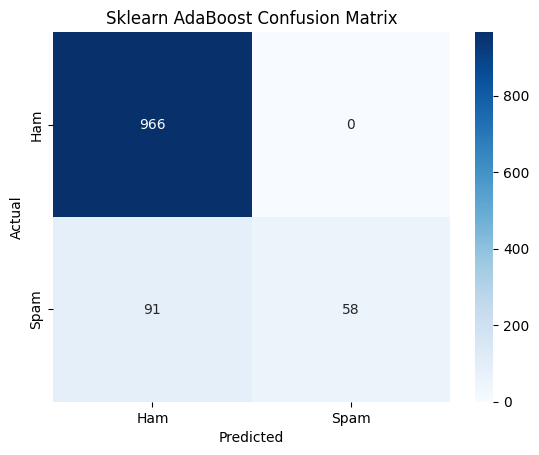

In [26]:
stump_sklearn = DecisionTreeClassifier(max_depth=1)

sklearn_ada = AdaBoostClassifier(estimator=stump_sklearn,n_estimators=100,learning_rate=0.6,random_state=42)

sklearn_ada.fit(X_train, y_train)

y_pred_train_sklearn = sklearn_ada.predict(X_train)
train_acc_sklearn = accuracy_score(y_train, y_pred_train_sklearn)
print(f"Train Accuracy: {train_acc_sklearn:.4f}")

y_pred_test_sklearn = sklearn_ada.predict(X_test)
test_acc_sklearn = accuracy_score(y_test, y_pred_test_sklearn)
print(f"Test Accuracy: {test_acc_sklearn:.4f}\n")

cm_sklearn = confusion_matrix(y_test, y_pred_test_sklearn)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Blues',xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Sklearn AdaBoost Confusion Matrix')
plt.show()

Dataset Description
You will use the UCI Heart Disease dataset (available in sklearn.datasets).
This dataset contains patient medical features used to predict heart disease.
Feature	Meaning
Age	Patient age
Sex	Gender (1 = male, 0 = female)
Cp	Chest pain type (0–3)
Trestbps	Resting blood pressure
Chol	Serum cholesterol (mg/dl)
Fbs	Fasting blood sugar >120 mg/dl (1/0)
Restecg	Resting ECG results
Thalach	Max heart rate achieved
Exang	Exercise-induced angina (1/0)
Oldpeak	ST depression induced by exercise
Slope	Slope of peak exercise ST segment
Ca	# of major vessels (0–3)
Thal	Thallium stress test result (0–3)
Target:
1 = heart disease present
0 = No heart disease

Part A — Baseline Model (Weak Learner)
1.	Load the dataset and preprocess (handle categorical features, scaling if needed)
2.	Train one Decision Stump (max_depth = 1)
3.	Report:
•	Training & test accuracy
•	Confusion matrix
•	Classification report
4.	What shortcomings do you observe in a single stump?


In [27]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

heart = fetch_openml(name="heart-disease", version=1, as_frame=True)

df = heart.frame
X = df.drop("target", axis=1)
y = df["target"]
feature_names = heart.feature_names
print(df.head())
print(df.shape)

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  3.0     145.0  233.0  1.0      0.0    150.0    0.0      2.3   
1  37.0  1.0  2.0     130.0  250.0  0.0      1.0    187.0    0.0      3.5   
2  41.0  0.0  1.0     130.0  204.0  0.0      0.0    172.0    0.0      1.4   
3  56.0  1.0  1.0     120.0  236.0  0.0      1.0    178.0    0.0      0.8   
4  57.0  0.0  0.0     120.0  354.0  0.0      1.0    163.0    1.0      0.6   

   slope   ca  thal  target  
0    0.0  0.0   1.0     1.0  
1    0.0  0.0   2.0     1.0  
2    2.0  0.0   2.0     1.0  
3    2.0  0.0   2.0     1.0  
4    2.0  0.0   2.0     1.0  
(303, 14)
Training data shape: (242, 13)
Testing data shape: (61, 13)


Training Accuracy: 0.7397
Test Accuracy: 0.8361



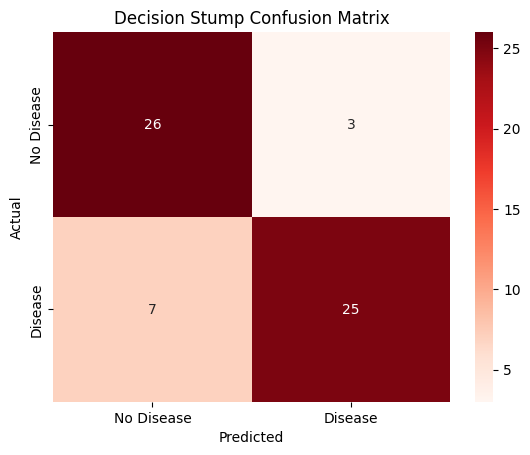

              precision    recall  f1-score   support

  No Disease       0.79      0.90      0.84        29
     Disease       0.89      0.78      0.83        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



In [28]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train_scaled, y_train)

y_pred_train_stump = stump.predict(X_train_scaled)
train_acc_stump = accuracy_score(y_train, y_pred_train_stump)

y_pred_test_stump = stump.predict(X_test_scaled)
test_acc_stump = accuracy_score(y_test, y_pred_test_stump)

print(f"Training Accuracy: {train_acc_stump:.4f}")
print(f"Test Accuracy: {test_acc_stump:.4f}\n")

cm_stump = confusion_matrix(y_test, y_pred_test_stump)
sns.heatmap(cm_stump, annot=True, fmt='d', cmap='Reds',xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Stump Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_test_stump, target_names=['No Disease', 'Disease']))

Part B — Train AdaBoost
1.	Train AdaBoostClassifier using decision stumps as base learners
2.	Use:
•	n_estimators = [5, 10, 25, 50, 100]
•	learning_rate = [0.1, 0.5, 1.0]
3.	For each combination:
•	Train model
•	Compute accuracy on test set
4.	Plot:
•	n_estimators vs accuracy for each learning_rate
5.	Identify best config (highest accuracy)


In [29]:
n_estimators_list = [5, 10, 25, 50, 100]
learning_rate_list = [0.1, 0.5, 1.0]

results = []
base_learner = DecisionTreeClassifier(max_depth=1, random_state=42)

for lr in learning_rate_list:
    for n_est in n_estimators_list:
        ada = AdaBoostClassifier(estimator=base_learner,n_estimators=n_est, learning_rate=lr, random_state=42)
        ada.fit(X_train_scaled, y_train)

        y_pred_test_ada = ada.predict(X_test_scaled)
        test_acc_ada = accuracy_score(y_test, y_pred_test_ada)

        results.append({'learning_rate': lr,'n_estimators': n_est,'test_accuracy': test_acc_ada})

results_df = pd.DataFrame(results)
print(results_df.head())

   learning_rate  n_estimators  test_accuracy
0            0.1             5       0.901639
1            0.1            10       0.885246
2            0.1            25       0.885246
3            0.1            50       0.868852
4            0.1           100       0.852459


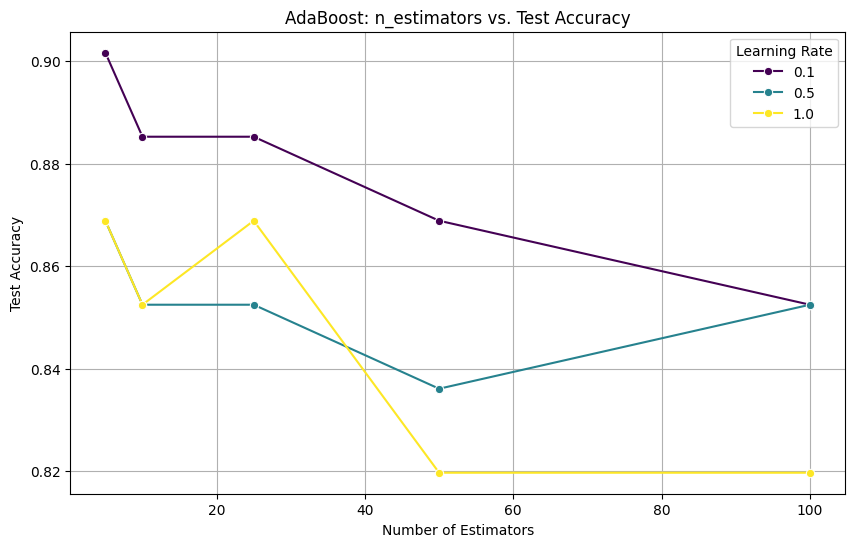

In [30]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='n_estimators', y='test_accuracy', hue='learning_rate', marker='o', palette='viridis')
plt.title('AdaBoost: n_estimators vs. Test Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()

In [31]:
best_config = results_df.loc[results_df['test_accuracy'].idxmax()]
print(f"Best configuration found:\n{best_config}")
print(f"\nHighest Test Accuracy: {best_config['test_accuracy']:.4f}")

best_lr = best_config['learning_rate']
best_n_est = int(best_config['n_estimators'])

Best configuration found:
learning_rate    0.100000
n_estimators     5.000000
test_accuracy    0.901639
Name: 0, dtype: float64

Highest Test Accuracy: 0.9016


Part C — Misclassification Pattern
1.	For the best model, collect the sample weights and prediction errors at each iteration.
2.	Plot:
•	Weak learner error vs iteration
•	Sample weight distribution after final boosting stage
3.	Explain:
•	Which samples got highest weights?
•	Why does AdaBoost focus on them?


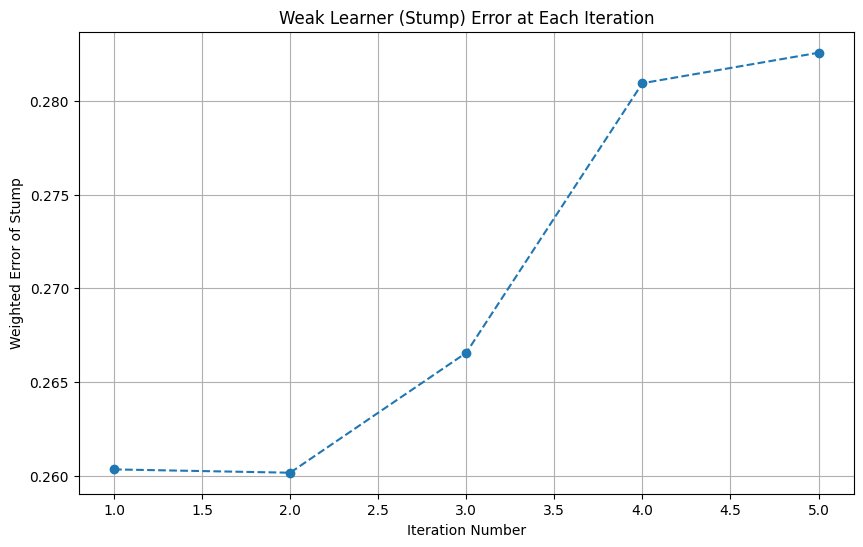

In [32]:
best_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42), n_estimators=best_n_est, learning_rate=best_lr, random_state=42)
best_model.fit(X_train_scaled, y_train)

learner_errors = best_model.estimator_errors_
plt.figure(figsize=(10, 6))
plt.plot(range(1, best_n_est + 1), learner_errors, marker='o', linestyle='--')
plt.title('Weak Learner (Stump) Error at Each Iteration')
plt.xlabel('Iteration Number')
plt.ylabel('Weighted Error of Stump')
plt.grid(True)
plt.show()

Part D — Visual Explainability
1.	Plot feature importance from AdaBoost.
2.	Identify top 5 most important features.
3.	Explain why these features may matter medically.


Length of importances: 13
Length of feature_names: 13
Top 5 most important features:
ca      0.399137
cp      0.397335
thal    0.203528
age     0.000000
sex     0.000000
dtype: float64



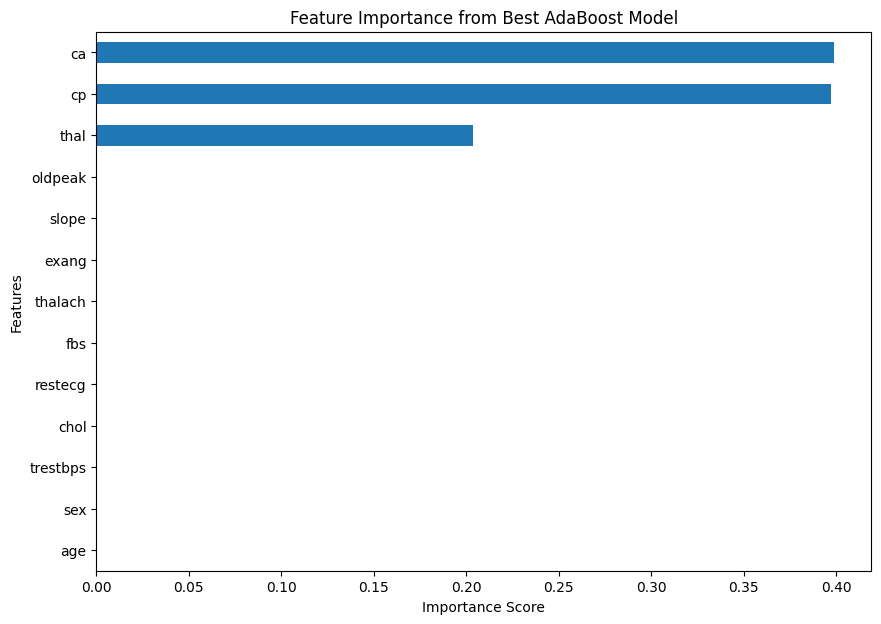

In [33]:
feature_names = heart.feature_names[:13]

importances = best_model.feature_importances_

print(f"Length of importances: {len(importances)}")
print(f"Length of feature_names: {len(feature_names)}")

feat_imp = pd.Series(importances, index=feature_names)

top_5_features = feat_imp.nlargest(5)
print(f"Top 5 most important features:\n{top_5_features}\n")

plt.figure(figsize=(10, 7))
feat_imp.sort_values().plot(kind='barh')
plt.title('Feature Importance from Best AdaBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

Q2. Dataset:
WISDM Smartphone & Watch Motion Sensor Dataset
(Available on UCI / Kaggle → WISDM_ar_v1.1_raw.txt)
Dataset Description
Collected from smartphones & smartwatches using accelerometer & gyroscope.
Attribute	Description
user_id	Person ID
Activity	type of physical activity (e.g., walking, jogging, sitting)
Timestamp	time in milliseconds
sensor readings	acceleration or gyroscope X, Y, Z values
Target prediction task:
•	Convert activity into binary label:
•	1 = vigorous motion (Jogging, Upstairs)
•	0 = light/static motion (Walking, Sitting, Standing, Downstairs)
We will use only accelerometer features (X, Y, Z).
Goal
Build an activity classifier using AdaBoost to distinguish between vigorous vs normal activity based on smartphone sensor accelerations.


In [34]:
import kagglehub
path = kagglehub.dataset_download("nusratuljannatmary/wisdmmar")

print("Path to dataset files:", path)

100%|██████████| 11.0M/11.0M [00:00<00:00, 91.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nusratuljannatmary/wisdmmar/versions/1


Part A — Data Preparation
1.	Load the dataset (WISDM_ar_v1.1_raw.txt)
2.	Extract only numeric accelerometer X, Y, Z columns
3.	Create activity label as binary:
Activity Type	Label
Jogging, Up	1
Walk, Sit, Stand, Down	0
4.	Handle missing/dirty entries
5.	Train-test split (70/30)


In [35]:
column_names = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']
df = pd.read_csv('WISDM_ar_v1.1_raw.txt', header=None, names=column_names, on_bad_lines='skip')
print(df.head())

   user_id activity       timestamp         x          y             z
0       33  Jogging  49105962326000 -0.694638  12.680544   0.50395286;
1       33  Jogging  49106062271000  5.012288  11.264028   0.95342433;
2       33  Jogging  49106112167000  4.903325  10.882658  -0.08172209;
3       33  Jogging  49106222305000 -0.612916  18.496431    3.0237172;
4       33  Jogging  49106332290000 -1.184970  12.108489     7.205164;


In [36]:
df['z'] = df['z'].astype(str).str.replace(';', '', regex=False)
df['z'] = pd.to_numeric(df['z'], errors='coerce')
df.dropna(inplace=True)

vigorous_activities = ['Jogging', 'Upstairs']
static_activities = ['Walking', 'Sitting', 'Standing', 'Downstairs']

df = df[df['activity'].isin(vigorous_activities + static_activities)].copy()
df['label'] = df['activity'].apply(lambda x: 1 if x in vigorous_activities else 0)

X = df[['x', 'y', 'z']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Data Shape:", X.shape)
print("Class Distribution (1=Vigorous, 0=Static):")
print(pd.Series(y).value_counts())
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Data Shape: (1086465, 3)
Class Distribution (1=Vigorous, 0=Static):
0    627151
1    459314
Name: count, dtype: int64

Training set shape: (760525, 3)
Test set shape: (325940, 3)


Part B — Weak Classifier Baseline
Train a Decision Stump:
DecisionTreeClassifier(max_depth=1)
Report:
•	Accuracy (train + test)
•	Confusion matrix
•	Interpretation of stump result


Baseline Stump Train Accuracy: 0.6521
Baseline Stump Test Accuracy:  0.6519


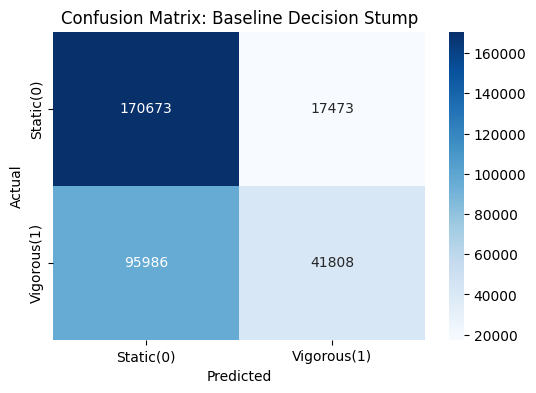

In [37]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_pred_train = stump.predict(X_train)
y_pred_test = stump.predict(X_test)

print(f"Baseline Stump Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Baseline Stump Test Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")

cm_stump = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_stump, annot=True, fmt='d', cmap='Blues', xticklabels=['Static(0)', 'Vigorous(1)'], yticklabels=['Static(0)', 'Vigorous(1)'])
plt.title("Confusion Matrix: Baseline Decision Stump")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Part C — Manual AdaBoost (T = 20 rounds)
Write your own AdaBoost with full weight tracking.
At each iteration, print:
•	Iteration number
•	Misclassified sample indices
•	Weights of misclassified samples
Note: Normalize weights after update.
Also plot:
•	Boosting round vs error
•	Boosting round vs alpha
Finally report:
•	Train accuracy
•	Test accuracy
•	Confusion matrix
•	Interpretation: how weights shifted over time


Iter  | Alpha      | Error      | Misclassified Count
------------------------------------------------------------
1     | 0.3142     | 0.3479     | 264567
2     | 0.0703     | 0.4649     | 288779
3     | 0.1026     | 0.4489     | 439005
4     | 0.1026     | 0.4489     | 300395
5     | 0.0851     | 0.4576     | 439005
6     | 0.0788     | 0.4607     | 291148
7     | 0.0701     | 0.4650     | 439005
8     | 0.0742     | 0.4630     | 288084
9     | 0.0636     | 0.4683     | 439005
10    | 0.0593     | 0.4704     | 302185
11    | 0.0532     | 0.4734     | 439005
12    | 0.0498     | 0.4751     | 291383
13    | 0.0457     | 0.4772     | 439005
14    | 0.0432     | 0.4784     | 295468
15    | 0.0401     | 0.4799     | 439005
16    | 0.0366     | 0.4817     | 307181
17    | 0.0347     | 0.4827     | 439005
18    | 0.0427     | 0.4787     | 290658
19    | 0.0392     | 0.4804     | 439005
20    | 0.0678     | 0.4661     | 302695


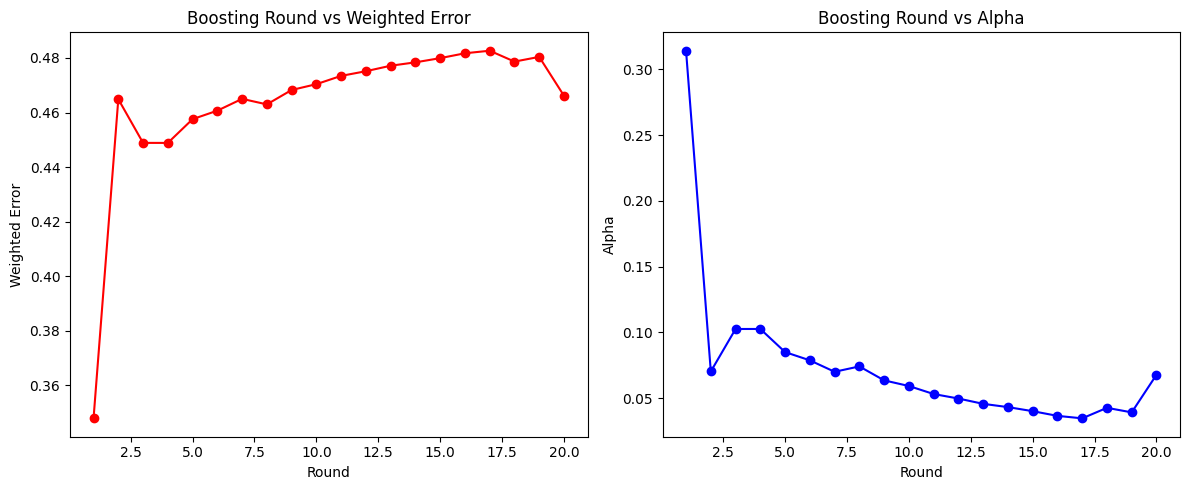

Train Accuracy: 0.6961
Test Accuracy:  0.6954


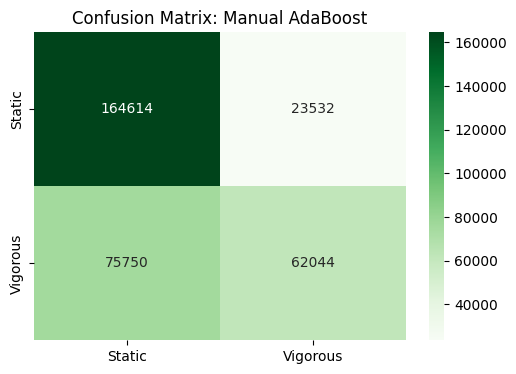

In [38]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
T = 20

sample_weights = np.full(n_train, 1 / n_train)
clfs = []
alphas = []
errors_history = []
alpha_history = []

y_train_ada = np.where(y_train == 0, -1, 1)
y_test_ada = np.where(y_test == 0, -1, 1)

print(f"{'Iter':<5} | {'Alpha':<10} | {'Error':<10} | {'Misclassified Count'}")
print("-" * 60)

for t in range(T):
    clf = DecisionTreeClassifier(max_depth=1, random_state=42)
    clf.fit(X_train, y_train, sample_weight=sample_weights)

    pred_01 = clf.predict(X_train)
    pred_ada = np.where(pred_01 == 0, -1, 1)

    misclassified_mask = (pred_ada != y_train_ada)

    error = np.dot(sample_weights, misclassified_mask)

    error = np.clip(error, 1e-10, 1 - 1e-10)

    alpha = 0.5 * np.log((1 - error) / error)

    clfs.append(clf)
    alphas.append(alpha)
    errors_history.append(error)
    alpha_history.append(alpha)

    misclassified_indices = np.where(misclassified_mask)[0]
    misclassified_weights = sample_weights[misclassified_indices]

    print(f"{t+1:<5} | {alpha:.4f}     | {error:.4f}     | {len(misclassified_indices)}")
    if len(misclassified_weights) > 0:
        pass

    sample_weights *= np.exp(-alpha * y_train_ada * pred_ada)
    sample_weights /= np.sum(sample_weights)

final_scores_train = np.zeros(n_train)
for clf, alpha in zip(clfs, alphas):
    p = clf.predict(X_train)
    p_mapped = np.where(p == 0, -1, 1)
    final_scores_train += alpha * p_mapped
final_pred_train = np.where(final_scores_train >= 0, 1, 0)

final_scores_test = np.zeros(n_test)
for clf, alpha in zip(clfs, alphas):
    p = clf.predict(X_test)
    p_mapped = np.where(p == 0, -1, 1)
    final_scores_test += alpha * p_mapped
final_pred_test = np.where(final_scores_test >= 0, 1, 0)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, T+1), errors_history, marker='o', color='red')
plt.title('Boosting Round vs Weighted Error')
plt.xlabel('Round')
plt.ylabel('Weighted Error')

plt.subplot(1, 2, 2)
plt.plot(range(1, T+1), alpha_history, marker='o', color='blue')
plt.title('Boosting Round vs Alpha')
plt.xlabel('Round')
plt.ylabel('Alpha')

plt.tight_layout()
plt.show()

print(f"Train Accuracy: {accuracy_score(y_train, final_pred_train):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, final_pred_test):.4f}")

cm_manual = confusion_matrix(y_test, final_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_manual, annot=True, fmt='d', cmap='Greens', xticklabels=['Static', 'Vigorous'], yticklabels=['Static', 'Vigorous'])
plt.title("Confusion Matrix: Manual AdaBoost")
plt.show()

Part D — Sklearn AdaBoost
Train:
AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=1),
    n_estimators = 100,
    learning_rate = 1.0
)
Report:
•	Train/Test accuracy
•	Confusion matrix
•	Compare with your manual implementation


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Train Accuracy: 0.6976
Test Accuracy:  0.6969


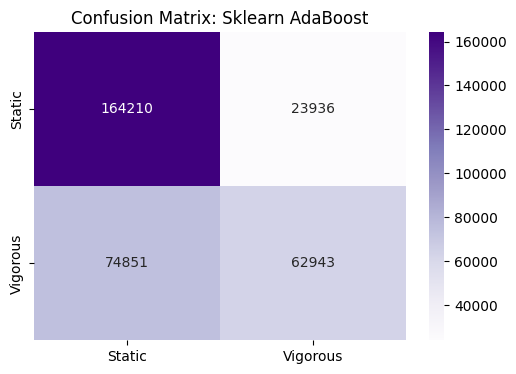

In [39]:
ada_sk = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=1.0, algorithm='SAMME', random_state=42)

ada_sk.fit(X_train, y_train)

y_pred_sk_train = ada_sk.predict(X_train)
y_pred_sk_test = ada_sk.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_pred_sk_train):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_pred_sk_test):.4f}")

cm_sk = confusion_matrix(y_test, y_pred_sk_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sk, annot=True, fmt='d', cmap='Purples', xticklabels=['Static', 'Vigorous'], yticklabels=['Static', 'Vigorous'])
plt.title("Confusion Matrix: Sklearn AdaBoost")
plt.show()